# Agentic RAG with Local Ollama Model
This notebook demonstrates how to build a Retrieval-Augmented Generation (RAG) agent using LangGraph, LangChain, and a local  model run via Ollama.

Adapted from: https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/

## Materials
This notebook and all materials referenced here can be found on Sol `/data/sse/ai-accelerated-spark`.

## 1. Import libraries

In [1]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import Tool
from langgraph.graph import Graph
from langchain.text_splitter import CharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import torch
from typing import List
from pydantic import BaseModel, Field
import os

os.environ["USER_AGENT"] = "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/109.0"

2025-06-24 19:43:42.266120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750819422.438538 1157730 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750819422.490892 1157730 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750819422.839675 1157730 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750819422.839690 1157730 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750819422.839692 1157730 computation_placer.cc:177] computation placer alr

## 2. Preprocess documents
### 2.1. Fetch documents

In [2]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://medium.com/cupy-team/announcing-cupy-v13-66979ee7fab0",
    "https://www.unum.cloud/blog/2022-01-26-cupy",
    "https://medium.com/rapids-ai/easy-cpu-gpu-arrays-and-dataframes-run-your-dask-code-where-youd-like-e349d92351d"
]

docs = [WebBaseLoader(url).load() for url in urls]

In [3]:
docs[0][0].page_content.strip()[:1000]

'Announcing CuPy v13. We are happy to announce that CuPy v13… | by Kenichi Maehashi | CuPy | MediumSitemapOpen in appSign upSign inMedium LogoWriteSign upSign inCuPy·NumPy & SciPy for GPU − News from the CuPy TeamAnnouncing CuPy v13Kenichi MaehashiFollow3 min read·Jan 18, 2024--ListenShareWe are happy to announce that CuPy v13 is now available. This new major release contains the effort of over 270 pull requests, including more SciPy-compatible routines and better packaging. Let’s check out the highlights:Signal Processing APIs − `cupyx.scipy.signal`In this release, we have added 140 signal processing routines that are compatible with SciPy’s scipy.signal.* APIs. The API Reference lists all the available signal functions. This work has been done by Evgani Burovski and Edgar Andrés Margffoy Tuay from Quansight, under the support of CZI’s Essential OSS for Science program.We would also like to highlight cuSignal’s contributions in this release. cuSignal is a library developed by the NVID

### 2.2. Split the fetched documents into smaller chunks for indexing into the vectorstore

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [5]:
doc_splits[0].page_content

'Announcing CuPy v13. We are happy to announce that CuPy v13… | by Kenichi Maehashi | CuPy | MediumSitemapOpen in appSign upSign inMedium LogoWriteSign upSign inCuPy·NumPy & SciPy for GPU − News from the CuPy TeamAnnouncing CuPy v13Kenichi MaehashiFollow3 min read·Jan 18, 2024--ListenShareWe are happy to announce that CuPy v13 is now'

## 3.Create a retriever tool
### 3.1. Use an in-memory vector store and all-MiniLM-L6-V2 embeddings model

In [6]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vectorstore = InMemoryVectorStore.from_documents(
    documents = doc_splits, embedding = embedding_model
)
retriever = vectorstore.as_retriever()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# TODO: Use ChromaDB for persistent vectorstore
# https://python.langchain.com/docs/integrations/vectorstores/

### 3.2. Create a retriever tool using LangChain's prebuild `create_retriever_tool`

In [8]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_python_gpu_acceleration",
    "Search and return information about accelerating Python code using the GPU with RAPIDS and CuPy.",
)

### 3.3. Test the tool

In [9]:
retriever_tool.invoke({"query": "How can I create a CuPy-backed Dask array for random data?"})

'chunksize=(2, 5), \\chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with dask.config.set({“array.backend”: “cupy”}):…    darr = da.random.randint(0, 3, size=(10, 20), chunks=(2, 5)) #\n\n= rs.randint(0, 3, size=(10, 20), chunks=(2, 5))>>> darrdask.array<randint, shape=(10, 20), dtype=int64, chunksize=(2, 5), \\chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with\n\nfor random array creation. Previously, if a user wanted to create a CuPy-backed Dask array, they were required to define an explicit RandomState object in Dask using CuPy. For example, the following code worked prior to Dask 2022.10.0, but seems rather verbose:>>> import cupy>>> import dask.array as da>>> rs = da.random.RandomState(RandomState=cupy.random.RandomState)>>>>>> darr =\n\n\\chunktype=cupy.ndarray>The chunktype informs us that the array is constructe

## 4. Generate query
### 4.1. Load local LLM

Start ollama using the terminal:
```bash
module load ollama/0.9.0
export OLLAMA_MODELS=/data/datasets/community/ollama
ollama-start
```

Check the available list of models using `ollama list`. Let me know via Slack if you would like to use and test other models.

In [13]:
from langchain_ollama import ChatOllama
import socket
from langchain_ollama.llms import OllamaLLM
from langchain.chat_models import init_chat_model

host_node = socket.gethostname()
llm_model = init_chat_model("ollama:qwen3:14b", temperature=0, base_url=f"http://vpatel69@{host_node}:11434/")

### 4.2. Build a `generate_query_or_respond` node

In [14]:
from langgraph.graph import MessagesState
import re

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        llm_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    # remove thinking text
    content = re.sub(r"<think>.*</think>", "", response.content, flags=re.DOTALL).strip()
    response.content = content
    return {"messages": [response]}

### 4.3. Try a random input

In [15]:
input = {"messages": [{"role": "user", "content": "Hello! What is the color of the sky?"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

The color of the sky is typically blue during the day due to a phenomenon called Rayleigh scattering, where shorter wavelengths of light (blue and violet) are scattered more by the atmosphere. However, the tools provided are not applicable for answering this question, as they are focused on Python GPU acceleration techniques. Let me know if you'd like information about that!


### 4.4. Try semantic search question

In [16]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "How can I create a CuPy-backed Dask array for random data?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_python_gpu_acceleration (48230ad8-4fbe-4e31-80a1-a67573da4a97)
 Call ID: 48230ad8-4fbe-4e31-80a1-a67573da4a97
  Args:
    query: Creating CuPy-backed Dask arrays for random data


## 5. Grade documents
### 5.1. Add conditional edge `grade_documents` to determine the relevance of retrieved documents

In [17]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        llm_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

### 5.2. Try with irrelevant documents in the tool response

In [18]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

### 5.3. Try with relevant documents

In [19]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": 'Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with dask.config.set({“array.backend”: “cupy”}):…    darr = da.random.randint(0, 3, size=(10, 20), chunks=(2, 5)) #\n\n= rs.randint(0, 3, size=(10, 20), chunks=(2, 5))>>> darrdask.array<randint, shape=(10, 20), dtype=int64, chunksize=(2, 5), \\chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with\n\nfor random array creation.',
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## 6.
### 6.1

In [20]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm_model.invoke([{"role": "user", "content": prompt}])
    # remove thinking text
    content = re.sub(r"<think>.*</think>", "", response.content, flags=re.DOTALL).strip()
    response.content = content
    return {"messages": [{"role": "user", "content": response.content}]}

### 6.2 Test

In [21]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

**Improved Question:**  
How can I generate a large random dataset using CuPy's GPU acceleration and integrate it with Dask arrays for parallel processing, including the necessary steps to ensure compatibility between CuPy and Dask, optimal chunk sizing, and efficient memory management?  

**Rationale for Improvement:**  
The revised question explicitly addresses:  
1. **Integration of CuPy and Dask** (clarifying the need for compatibility checks).  
2. **Use case** (generating large random data for parallel processing).  
3. **Implementation details** (chunk sizing, memory management, and best practices).  
4. **Underlying intent** (leveraging GPU acceleration with Dask for scalability).  
This avoids ambiguity and guides the responder to address both technical steps and performance considerations.


## 7. Generate an answer
### 7.1. Build `generate_answer` node

In [22]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm_model.invoke([{"role": "user", "content": prompt}])
    # remove thinking text
    content = re.sub(r"<think>.*</think>", "", response.content, flags=re.DOTALL).strip()
    response.content = content
    return {"messages": [response]}

## 7.2 Test

In [23]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_python_gpu_acceleration",
                        "args": {"query": "creating CuPy-backed Dask arrays for random data"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": 'Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with dask.config.set({“array.backend”: “cupy”}):…    darr = da.random.randint(0, 3, size=(10, 20), chunks=(2, 5)) #\n\n= rs.randint(0, 3, size=(10, 20), chunks=(2, 5))>>> darrdask.array<randint, shape=(10, 20), dtype=int64, chunksize=(2, 5), \\chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with\n\nfor random array creation.',
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

To create a CuPy-backed Dask array for random data, set the `array.backend` configuration to `"cupy"` using `dask.config.set`. Use `da.random.randint` with desired parameters, such as `size=(10, 20)` and `chunks=(2, 5)`. This generates a Dask array with CuPy as the underlying backend.


## 8. Assemble the graph

In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

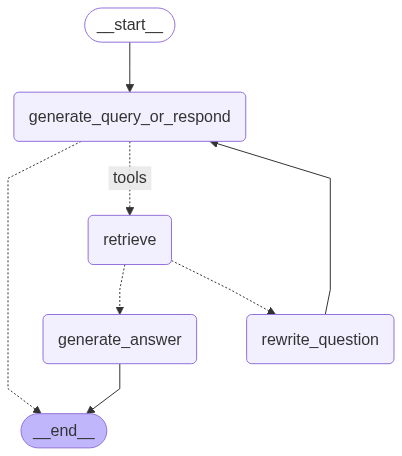

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 9. Run the agentic RAG

In [26]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How can I create a CuPy-backed Dask array for random data?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_python_gpu_acceleration (63bcc3bb-e83b-4e99-875f-43e19925416d)
 Call ID: 63bcc3bb-e83b-4e99-875f-43e19925416d
  Args:
    query: creating CuPy-backed Dask arrays for random data



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_python_gpu_acceleration

= rs.randint(0, 3, size=(10, 20), chunks=(2, 5))>>> darrdask.array<randint, shape=(10, 20), dtype=int64, chunksize=(2, 5), \chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with

chunksize=(2, 5), \chunktype=cupy.ndarray>Now, we can leverage the array.backend configuration to create a CuPy-backed Dask array for random data:>>> with dask.config.set({“array.backend”: “cupy”}):…    darr = da.random.randint(0, 3, size=(10, 20), chunks=(2, 5)) 

## 10. Graphic User Interface using Gradio

In [27]:
import gradio as gr

def ask_graph(user_input, chat_history):
    result = graph.invoke({
        "messages": [
            {"role": "user", "content": user_input}
        ]
    })

    response = result["messages"][-1].content

    if not chat_history:
        response = [{"role": "user", "content": user_input}, {"role": "assistant", "content": response}]
    else:
        response = chat_history + [{"role": "user", "content": user_input}, {"role": "assistant", "content": response}]

    return "", response

def clear_conversation():
    return "", ""

with gr.Blocks(fill_height=True, fill_width=True) as demo:
    gr.Markdown("### Agentic RAG")

    with gr.Column():

        with gr.Row():
            chatbot = gr.Chatbot(height=350, type="messages")

        with gr.Row():
            with gr.Column(scale=4):
                query_input = gr.Textbox(
                    label="Enter text here", placeholder="Ask something...", lines=1
                    )
            with gr.Column(scale=1):
                with gr.Row():
                    submit_btn = gr.Button("⬆")
                # 🧹 Clear button
                with gr.Row():
                    clear_btn = gr.Button("🧹 Clear Conversation")

        submit_btn.click(
            fn=ask_graph,
            inputs=[query_input, chatbot],
            outputs=[query_input, chatbot],
        )

        query_input.submit(
            fn=ask_graph,
            inputs=[query_input, chatbot],
            outputs=[query_input, chatbot],
        )

        clear_btn.click(
            fn=clear_conversation,
            outputs=[query_input, chatbot],
        )

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://292845baf2334672d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
